In [1]:
# import the libraries from the CH4 lab
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
## more libraries
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
## extra libraries that are needed

**13.** This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

**(a)** Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [2]:
weekly = load_data('Weekly')
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1089 non-null   int64   
 1   Lag1       1089 non-null   float64 
 2   Lag2       1089 non-null   float64 
 3   Lag3       1089 non-null   float64 
 4   Lag4       1089 non-null   float64 
 5   Lag5       1089 non-null   float64 
 6   Volume     1089 non-null   float64 
 7   Today      1089 non-null   float64 
 8   Direction  1089 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 69.4 KB


In [3]:
weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


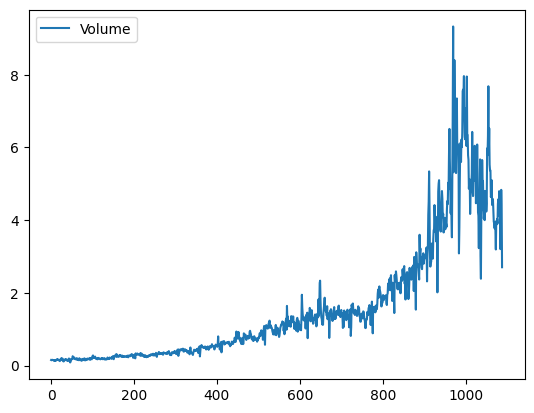

In [4]:
weekly.plot(y='Volume');

There is an increasing trend most of the data, and decreasig one towards the end. This can also be seen in the correlation between year and volume.

**(b)** Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [5]:
allvars = weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(weekly)
y = weekly.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)


,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Smallest p-value is for Lag2, therefore it is the most significant predictor. 

**(c)** Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [6]:
probs = results.predict()
#
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"
confusion_table(labels, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


Diagonals give the number of correct prediction, and off-diagonals give the incorrect predictions. error rate is 478/1089 = 43.9%

**(d)** Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [7]:
## select train and test sets
train = (weekly.Year < 2009)
weekly_train = weekly.loc[train]
weekly_test = weekly.loc[~train]
weekly_test.shape
# fit the model with Lag2 only
X = MS(['Lag2']).fit_transform(weekly)
y = weekly.Direction == 'Up'
#
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
##
D = weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]
##
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


the error rate is 37.5%, which is lower than training error rate if we use all the Lag data. 

**(e)** Repeat (d) using LDA.

In [8]:
##
lda = LDA(store_covariance=True)
##
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,True
,tol,0.0001
,covariance_estimator,None
